In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

/Users/babraham/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


This notebook contains plots that examine different characteristics of a Synthea population including:

- Age
- Race
- Healthcare Cost
- Medication Cost and Usage
- Disease Prevalanece
- Birthweights

Areas of future exploration include labs, and procedures. Eventually, this analysis will be extended to compare population characteristics to real data. 

# Synthea Snapshot Plots

### Setup/Config

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
%load_ext autoreload

In [13]:
data_dir = '../data-set' # data directory containing synthea data (can either be csvs or zips)
readzips = True # specifies whether the files are compressed (zip) or not

### Import Data

In [59]:
if readzips:
    compress_opt = 'zip'
    ext = 'zip'
else:
    compress_opt = 'infer'
    ext = 'csv'

patients = pd.read_csv('{}/patients.{}'.format(data_dir, ext), compression=compress_opt)
conditions = pd.read_csv('{}/conditions.{}'.format(data_dir, ext), compression=compress_opt)
meds = pd.read_csv('{}/medications.{}'.format(data_dir, ext), compression=compress_opt)
# only read in first 100k observations
observations = pd.read_csv('{}/observations.{}'.format(data_dir, ext), nrows=1000000, compression=compress_opt)
encounters = pd.read_csv('{}/encounters.{}'.format(data_dir, ext), compression=compress_opt)

### Pre-Processing (Age and Race)

In [60]:
from dateutil import relativedelta

# pre-processing
def race_clean(race, ethnicity):
    if race.lower() =='white' and ethnicity.lower()=='hispanic':
        return 'hispanic'
    else:
        return race.lower()

def calc_age_in_years(birth_date, death_date=np.nan):
    assert birth_date is not None
    start_date = pd.Timestamp(birth_date) if type(birth_date) is str else birth_date
    end_date = pd.Timestamp.today() if type(death_date) is float else pd.Timestamp(death_date)
    rel_del = relativedelta.relativedelta(end_date, start_date)
    return np.round(rel_del.years + rel_del.months / 12.0, 1)

def get_age_bin(age, bin_size=10):
    idx = np.floor(age/bin_size)
    bin_name = '{}-{}'.format(int(bin_size*idx), int(bin_size*(idx+1)))
    return bin_name

# add new race column (# TODO: fix this to be consistent with census guidelines) and age bins

patients['RACE2'] = patients.apply(lambda x: race_clean(x['RACE'],x['ETHNICITY']), axis=1)
patients['AGE'] = patients.apply(lambda pat: calc_age_in_years(pat['BIRTHDATE'], pat['DEATHDATE']), axis=1)
patients['AGE_BIN'] = patients['AGE'].apply(lambda age: get_age_bin(age))
patients['ALIVE'] = patients['DEATHDATE'].apply(lambda d: type(d) is float)
patients['PATIENT'] = patients['Id']


## Age Distrirbutions

### Overall

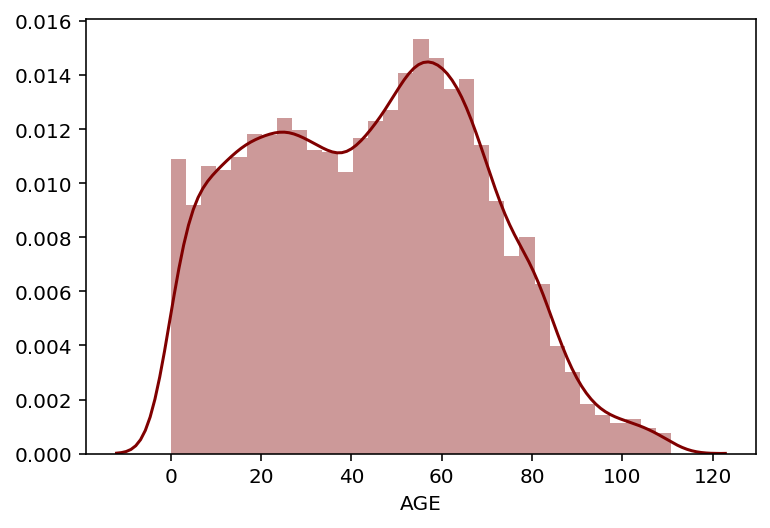

In [61]:
sns.distplot(patients['AGE'], color='maroon')

### By Race

In [62]:
races = set(patients['RACE2'].unique()).difference(['other'])
age_race_data = map(lambda race: patients.loc[patients['RACE2']==race,'AGE'].values, races)

hist_data = [datalist for datalist in age_race_data]

colors = ['#A56CC1', '#A6ACEC', '#63F5EF']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, list(races), show_rug=False)

# Add title
fig.update_layout(title_text='Age Distribution by Race')
fig.show()

## Race/Ethnicity Distribution

In [63]:
race_cts['PATIENT']

RACE2
asian        674
black        895
hispanic     924
native        45
other         11
white       7451
Name: PATIENT, dtype: int64

In [64]:
measure = 'RACE2'
df = patients
race_cts = df[df['ALIVE']==True].loc[:,[measure, 'PATIENT']].groupby(measure).count()
race_cts['pct'] = np.round(100 * race_cts['PATIENT'] / race_cts['PATIENT'].sum(), 2) 
race_cts['race'] = race_cts.index.tolist()
fig = px.pie(race_cts, values='PATIENT', labels = 'race', names = 'race',
             hover_data=['PATIENT'])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

## Geographic Distribution

In [65]:
import us
CITY_FILE = '../data/1000-largest-us-cities.csv'
def load_cities(city_file = CITY_FILE):
    us_cities = pd.read_csv(city_file, sep=';')
    coords = us_cities['Coordinates'].apply(lambda x: x.split(','))
    us_cities['LAT'] = [np.float(tup[0]) for tup in coords]
    us_cities['LON'] = [np.float(tup[1]) for tup in coords]
    us_cities['text'] = '<b>' + us_cities['City'] + ', ' + us_cities['State'] + '</b><br>Population: ' + us_cities['Population'].astype(str) + \
    " <br>Growth from '00-'13: " + us_cities['Growth From 2000 to 2013'].astype(str)
    return us_cities

us_cities = load_cities(CITY_FILE)
us_cities.head()

,City,Rank,State,Growth From 2000 to 2013,Population,Coordinates,LAT,LON,text
0,Marysville,552,Washington,115.7,63269,"48.0517637,-122.1770818",48.051764,-122.177082,"<b>Marysville, Washington</b><br>Population: 6..."
1,Perris,466,California,98.7,72326,"33.7825194,-117.2286478",33.782519,-117.228648,"<b>Perris, California</b><br>Population: 72326..."
2,Cleveland,48,Ohio,-18.1,390113,"41.49932,-81.6943605",41.499320,-81.694361,"<b>Cleveland, Ohio</b><br>Population: 390113 <..."
3,Worcester,129,Massachusetts,5.8,182544,"42.2625932,-71.8022934",42.262593,-71.802293,"<b>Worcester, Massachusetts</b><br>Population:..."
4,Columbia,192,South Carolina,11.7,133358,"34.0007104,-81.0348144",34.000710,-81.034814,"<b>Columbia, South Carolina</b><br>Population:..."


In [66]:
def get_local_cities(patient_df, usc=us_cities):
    min_lat = patient_df['LAT'].min()
    min_lon = patient_df['LON'].min()
    max_lat = patient_df['LAT'].max()
    max_lon = patient_df['LON'].max()

    usc_filtered = us_cities[(usc['LAT'] >= min_lat) & 
                            (usc['LAT'] <= max_lat) &
                            (usc['LON'] >= min_lon) &
                            (usc['LON'] <= max_lon)]
    
    usc_filtered.sort_values(by='Population', ascending=False, inplace=True)
    return usc_filtered

filtered = get_local_cities(patients)
filtered.head()

,City,Rank,State,Growth From 2000 to 2013,Population,Coordinates,LAT,LON,text
89,Boston,24,Massachusetts,9.4,645966,"42.3600825,-71.0588801",42.360082,-71.058880,"<b>Boston, Massachusetts</b><br>Population: 64..."
3,Worcester,129,Massachusetts,5.8,182544,"42.2625932,-71.8022934",42.262593,-71.802293,"<b>Worcester, Massachusetts</b><br>Population:..."
822,Providence,134,Rhode Island,2.3,177994,"41.8239891,-71.4128343",41.823989,-71.412834,"<b>Providence, Rhode Island</b><br>Population:..."
221,Springfield,158,Massachusetts,1.1,153703,"42.1014831,-72.589811",42.101483,-72.589811,"<b>Springfield, Massachusetts</b><br>Populatio..."
488,New Haven,195,Connecticut,5.5,130660,"41.308274,-72.9278835",41.308274,-72.927883,"<b>New Haven, Connecticut</b><br>Population: 1..."


In [69]:
# Where are people located?
num_cities = 10
pop_cutoff = 3e5
cdf = get_local_cities(patients).reset_index(drop=True)
df = patients.sample(n=3000)
scale = 5000

# Make a text column to display info about patients on map
df['text'] = df['FIRST'] + ' ' + df['LAST'] + ' (' + df['Id'] + ')\n' + df['GENDER'] + ', ' + df['RACE'] + ', '+ df['AGE'].astype(str) + ' yrs old'

fig = go.Figure()

map_plot = go.Scattergeo(
        name = 'Patients',
        lon = df['LON'],
        lat = df['LAT'],
        hoverinfo='none',
        mode = 'markers',
        marker = dict(
            color = 'gray',
            line_color='rgb(40,40,40)',
            line_width=0.5,
            opacity=.4
        )
)
cdf_sub = cdf[cdf['Population'] > pop_cutoff]

city_lbls = go.Scattergeo(
    lon =cdf_sub['LON'],
    lat =cdf_sub['LAT'],
    mode="markers+text",
    name="Cities",
    text=cdf_sub['City'],
    hovertext=cdf_sub['text'],
    textposition="top center",
    
    marker = dict(
        size = cdf['Population']/scale,
        color = 'red',
        line_color='rgb(236,240,244)',
        line_width=0.5,
        sizemode = 'area',
        opacity=.7
    ), 
    hovertemplate=
    "<b>%{text}</b><br>" +
    "Population: %{marker.size:,}" +
    "<extra></extra>",
    textfont=dict(
        size=12,
        color="rgb(24,162,185)"
    )
)

fig.add_trace(map_plot)
fig.add_trace(city_lbls)


fig.update_layout(
        title = 'Synthea Population Desnity and Cities with over 600k People ',
        geo_scope='usa',
    )
    
fig.update_geos(fitbounds="locations")

fig.show()


## Age, Healthcare Expenses and Expense Coverage by Race

Plot that shows pairwise relationships between Age, Healthcare expense, and healthcare coverage by race. Plots in the middle are univariate distributions broken down by race, while the off-diagonal plots are pairwise sactterplots. 

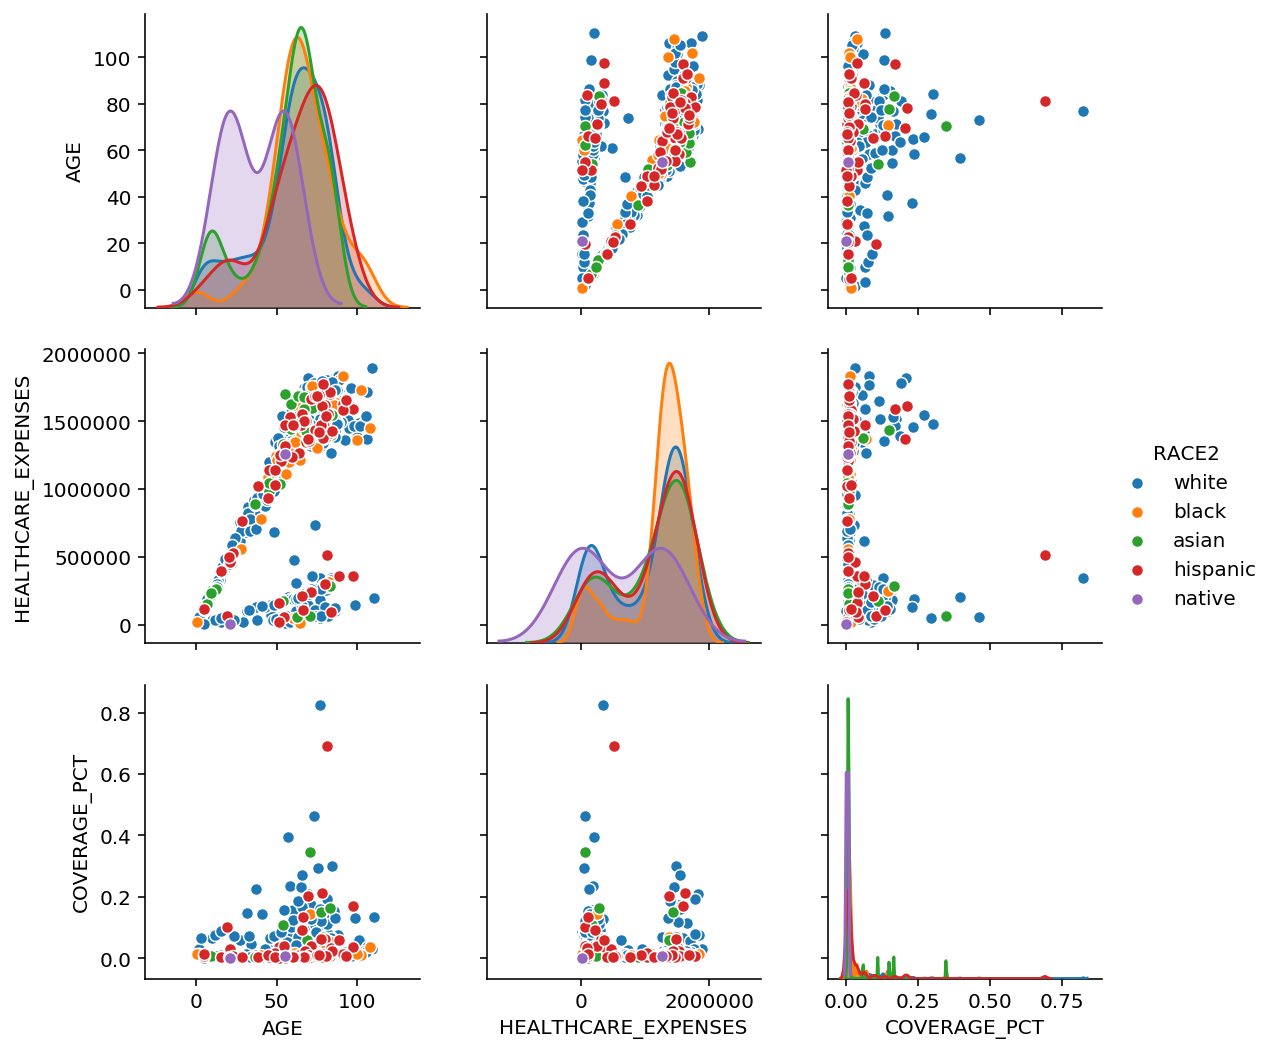

In [70]:
group_col = 'RACE2'
df['COVERAGE_PCT'] = df['HEALTHCARE_COVERAGE'] / df['HEALTHCARE_EXPENSES']
metrics = ['AGE', 'HEALTHCARE_EXPENSES', 'COVERAGE_PCT']

metrics.append(group_col)
df_sub = df.loc[(df['ALIVE']==False) & (df['COVERAGE_PCT'] <=1), metrics]
sns.pairplot(df_sub, hue=group_col)
#df_sub.describe()
plt.show()

## Disease Prevalence

In [71]:
patients.loc[:,'PATIENT'] = patients['Id']
demos = ['PATIENT', 'AGE', 'AGE_BIN', 'RACE2', 'GENDER']
conds_w_demos = conditions.join(patients[demos].set_index('PATIENT'), on='PATIENT')
cond_cts = (conditions.loc[:,['ENCOUNTER','DESCRIPTION']]
            .groupby('DESCRIPTION').count()
            .sort_values(by='ENCOUNTER', ascending=False))
race_cond_cts = conditions.loc[:,['ENCOUNTER', 'DESCRIPTION']]
all_conds = cond_cts.index.tolist()

In [72]:
import numpy as np

def dec_to_pct(decimal):
    return '{}%'.format(np.round(decimal * 100, 2))

# assumes cat_cts index is category name (i.e. result of a counting function)
def simplify_cats(cat_cts, n=10, val_col='ENCOUNTER'):
    if cat_cts.shape[0] < n:
        return cat_cts.sort_values(by=val_col, ascending=True)
    else:
        top_cats = set(cat_cts.sort_values(by=val_col, ascending=False).index.tolist()[:n])
        cat_cts['new_cat'] = [x if x in top_cats else 'Other' for x in cat_cts.index]
        cat_cts = cat_cts.groupby('new_cat').sum()        
        return cat_cts.sort_values(by=val_col, ascending=True)

disorders = set(filter(lambda x: x.endswith('(disorder)'), all_conds))
findings = set(filter(lambda x: x.endswith('(finding)'), all_conds))
situations = set(filter(lambda x: x.endswith('(situation)'), all_conds))

d_cts = cond_cts.filter(items=disorders, axis=0)
# f_cts = cond_cts[cond_cts['Condition'].isin(findings)]
# s_cts = cond_cts[cond_cts['Condition'].isin(situations)]

MAX_CATS = 10
d_cts = simplify_cats(d_cts, MAX_CATS)
# d_cts = simplify_cats(d_cts, MAX_CATS)
# d_cts = simplify_cats(d_cts, MAX_CATS)

#d_cts
pcts = [dec_to_pct(val[0] / d_cts.sum()[0]) for val in d_cts.values]
dis_tr = go.Bar(x=d_cts['ENCOUNTER'], y=d_cts.index, orientation='h', text=pcts, textposition='auto')
d_fig = go.Figure(dis_tr)
d_fig.update_layout(barmode='stack', 
                   title_text='Top 10 Most Prevelanet Disorders in Texas Population')

### Disease Distribution by Race

In [73]:
race_cond_pivot = conds_w_demos.pivot_table(values='ENCOUNTER',index='RACE2',columns='DESCRIPTION', aggfunc=len)
races = set(race_cond_pivot.index.tolist()).difference(['other'])
race_cond_pivot = race_cond_pivot.filter(items=races, axis=0)
# only look at disorders
r_piv = race_cond_pivot.filter(regex='\(disorder\)$', axis=1)
# add column totals for disease normalization
r_piv.loc['Total',:] = r_piv.sum()
# clean up column names
r_piv.columns = [col.replace('(disorder)', '') for col in r_piv.columns]


# get top 10 disorders by total prevalence
top_dis_idxes = sorted([(i,total) for i,total in enumerate(r_piv.loc['Total',:].values)],\
                       key=lambda tup:tup[1], reverse=True)
disease_cols = [tup[0] for tup in top_dis_idxes[:10]]
race_df = r_piv.iloc[:,disease_cols]
# normalize race disease counts by column
races = set(race_df.index.tolist()).difference(['DESC', 'DESCRIPTION', 'Total'])
race_sums = race_df.loc[races,:].sum(axis=1)
race_norms = race_df.loc[races,:]
for i, race in enumerate(races):
    race_norms.loc[race, :] = race_norms.loc[race,:].apply(lambda col_val: np.round(col_val / race_sums[race],2))

race_cond_fig = go.Figure(data=[go.Bar(name=disease.capitalize(), x=race_norms.index.tolist(), y=race_norms[disease], text=race_norms[disease],
                                       textposition='inside') for disease in race_df.columns])

race_cond_fig.update_layout(barmode='stack', title_text='Distribution of Top 10 Disordes by Race')

## Medications

In [74]:
import re

def get_data_from_name(med_name):
    med_name = med_name.lower()
    try:
        keywd = re.findall('([aA-zZ ]+) [0-9]+', med_name)[0]
        keywd = re.sub('^[aA-zZ]{2} ', '', keywd.strip())
    except: keywd = None
    try: dose = re.findall('[0-9\.]+ [mM][gG]', med_name)
    except: dose = None
    return {'keywd': keywd, 'dose': dose}



meds['DESCRIPTION'] = meds['DESCRIPTION'].apply(lambda x: x.lower())
metadata = meds['DESCRIPTION'].apply(lambda x: get_data_from_name(x)).tolist()
met_df = pd.DataFrame(metadata)
meds = pd.concat([meds, met_df], axis=1)

In [75]:
N=15

cts = (meds[['keywd', 'DISPENSES']].groupby(by='keywd').sum()
       .reset_index())
keywds = cts['keywd'].tolist()
cts.index=keywds
cts = simplify_cats(cts, N, 'DISPENSES').reset_index()
cts['pct'] = [dec_to_pct(val / sum(cts['DISPENSES'])) for val in cts['DISPENSES']]
cts = cts[cts['new_cat'] != 'Other']

cts = cts.sort_values(by='DISPENSES', ascending=True)
fig = go.Figure(go.Bar(x=cts['DISPENSES'], y=cts['new_cat'], orientation='h', text=cts['pct'], textposition='auto'))
fig.update_layout(title_text='Top {} Most Frequently Dispensed Medications'.format(N), 
                 xaxis_title = 'Total Dispenses')
fig.update_traces(marker_color='rgb(55,83,109)')
fig.show()

In [76]:
med_pat_matrix = meds.pivot_table(values='DISPENSES',index='PATIENT',columns='keywd', aggfunc=sum)

In [77]:
patient_use_cts = med_pat_matrix.count().sort_values(ascending=False)
patient_use_cts = (patient_use_cts.reset_index()[:N]
                   .rename(columns={0:'count'}))
patient_use_cts['pct'] = [dec_to_pct(val / med_pat_matrix.shape[0]) for val in patient_use_cts['count']]
patient_use_cts = patient_use_cts.sort_values(by='count', ascending=True)
ct_fig = go.Figure(go.Bar(x=patient_use_cts['count'], y=patient_use_cts['keywd'], orientation='h',
                          text=patient_use_cts['pct'], textposition='auto'))
ct_fig.update_layout(title='Medications with Highest Market Penetration', 
                    xaxis_title='# of Patients that have Used')
ct_fig.update_traces(marker_color='rgb(24,162,185)')
ct_fig.show()

In [78]:
from functools import partial
import plotly.express as px

q_25 = partial(pd.Series.quantile, q=0.25)
q_25.__name__ = '25%'
q_75 = partial(pd.Series.quantile, q=0.75)
q_75.__name__ = '75%'
med_use_stats = (med_pat_matrix.agg(['count', 'mean', 'std', 'min', q_25, 'median', q_75, 'max'])
             .transpose()
             .sort_values(by='mean', ascending=False)
             .rename(columns={'mean': 'mean_use_ct', 'count': 'patients'})
            )
med_cost_stats = (meds.loc[:,['keywd','TOTALCOST']]
                  .groupby(by='keywd').describe()
                 )
med_cost_stats.columns = [c[1] + '_cost' for c in med_cost_stats.columns]
med_comb = med_use_stats.join(med_cost_stats)
med_comb['medication'] = med_comb.index

fig = px.scatter(med_comb, x="mean_use_ct", y="mean_cost",
         size="patients", hover_name="medication", log_x=True, log_y=True, size_max=60)
fig.update_layout(title='Medication Bubble Chart', 
                  xaxis_title='Avg. Uses per Patient',
                  yaxis_title ='Avg. Lifetime Cost per Patient')
fig.show()

## Labs

In [79]:
# TODO

## Procedures

In [80]:
# TODO

## Birthweight Distributions

In [81]:
def get_birthweights_by_group(data, group_col='RACE2', group='white'):
    all_weights = data.loc[data['DESCRIPTION']=='Body Weight',['PATIENT', 'VALUE', group_col]]
    group_weights = all_weights[all_weights[group_col]==group]
    group_weights['VALUE'] = pd.to_numeric(group_weights['VALUE'])
    group_birthweights = group_weights.groupby('PATIENT').min()
    return group_birthweights

def get_all_birthweights(obs_data, patient_data):
    all_weights = obs_data[obs_data['DESCRIPTION']=='Body Weight']
    all_weights['VALUE'] = pd.to_numeric(all_weights['VALUE'])
    all_birthweights = all_weights[['PATIENT', 'VALUE']].groupby('PATIENT').min()
    birthweight_df = all_birthweights.join(patient_data[pat_cols].set_index('PATIENT'), on=('PATIENT'))
    return birthweight_df

### Overall, By Race and By Gender

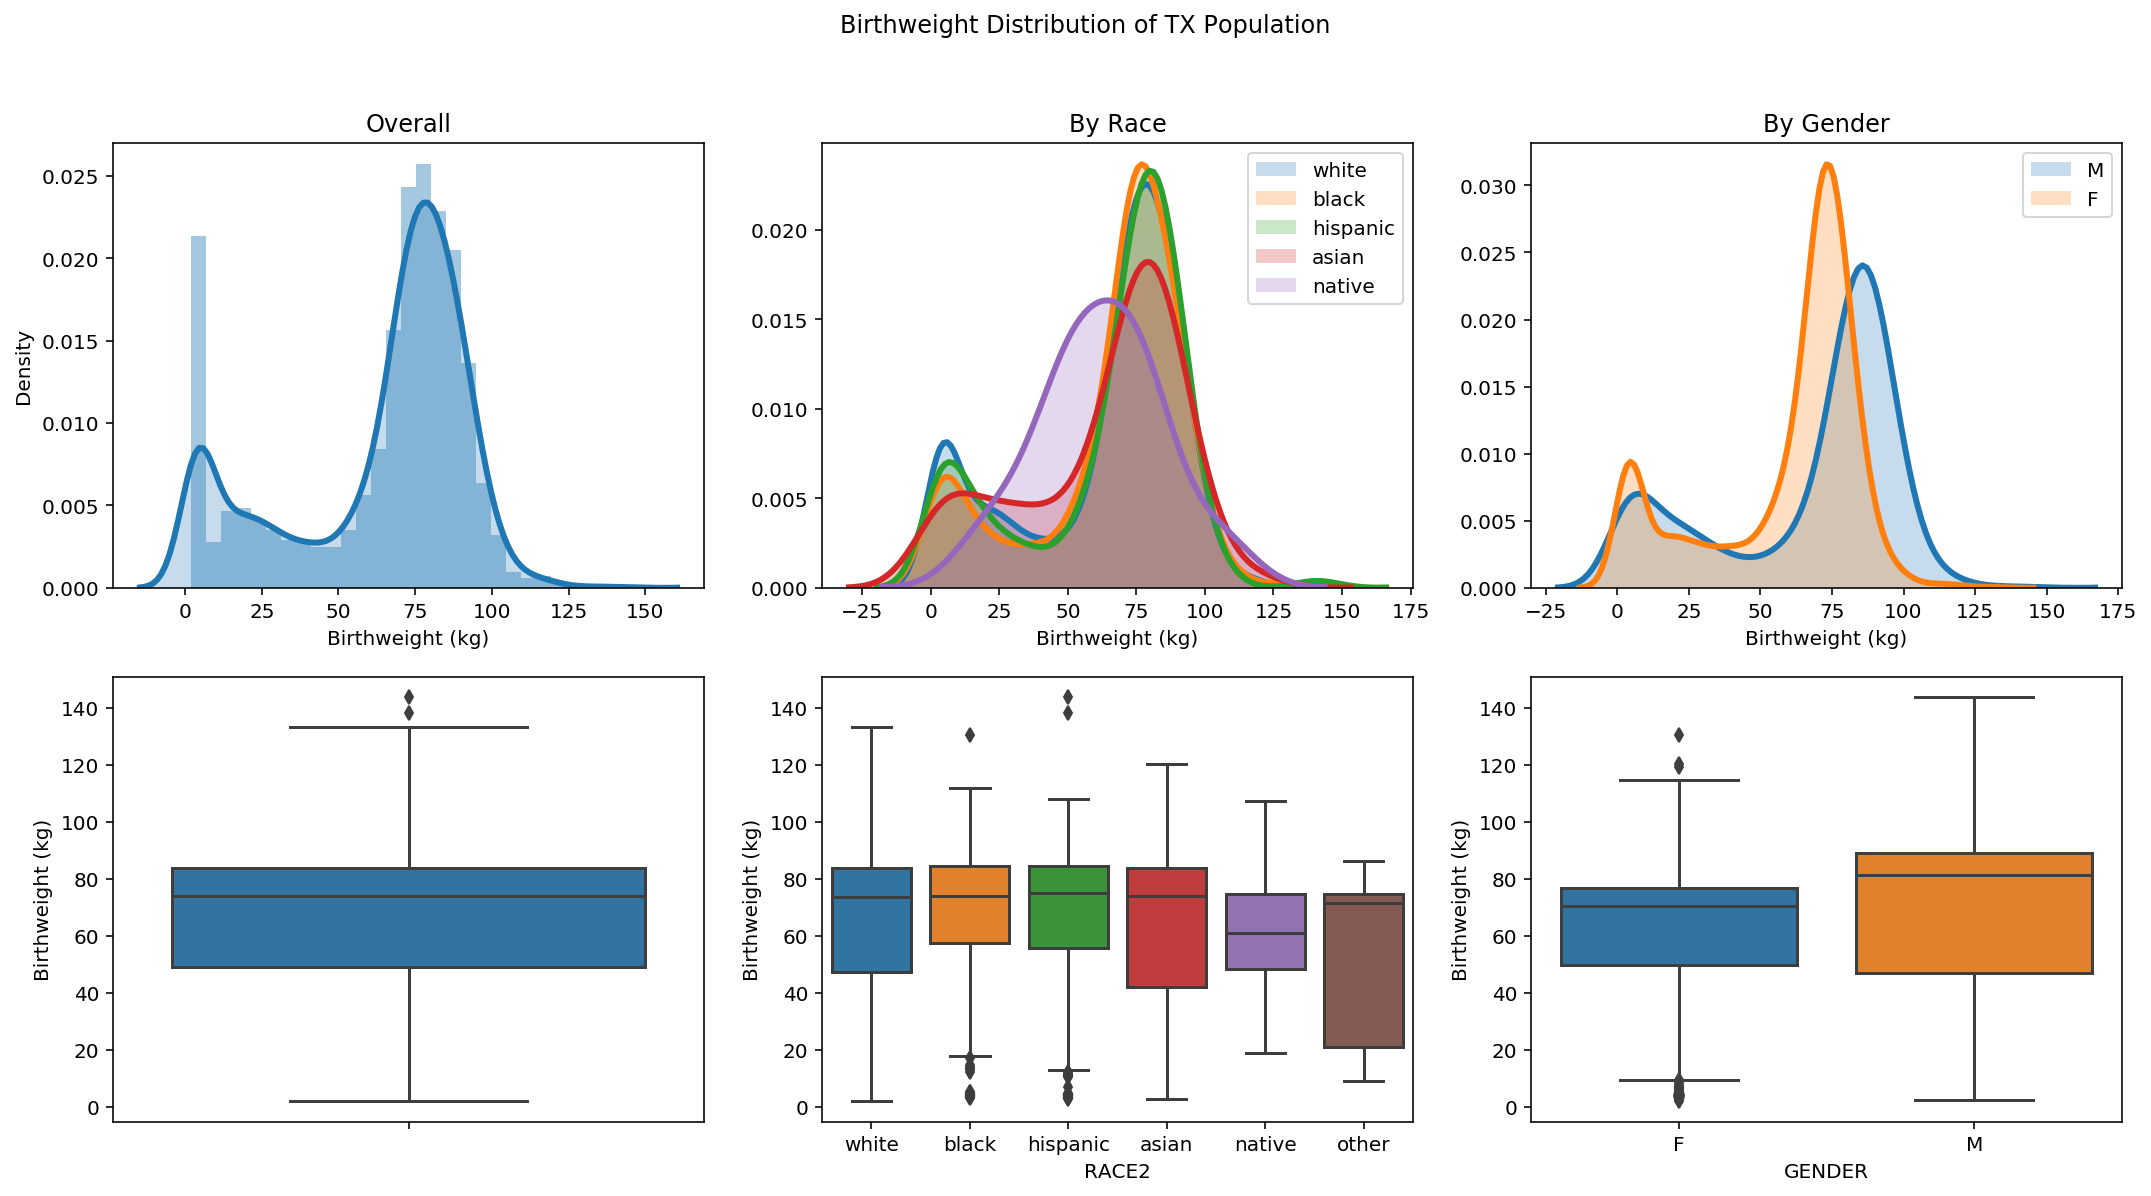

In [82]:

import matplotlib.pyplot as plt
import seaborn as sns

pat_cols = ['PATIENT','BIRTHDATE', 'DEATHDATE', 'AGE', 'COUNTY', 'GENDER', 'RACE2', 'ZIP','STATE', 'AGE_BIN']


obs_comb = observations.join(patients[pat_cols].set_index('PATIENT'), on=('PATIENT'))

bp_df = get_all_birthweights(observations, patients)
fig, axes = plt.subplots(2,3, figsize=(18,9))
fig.suptitle('Birthweight Distribution of TX Population')

# overall
sns.distplot(bp_df['VALUE'], hist=True,kde=True, kde_kws={'shade':True, 'linewidth':3},
                    ax=axes[0][0])
axes[0][0].set(xlabel='Birthweight (kg)', ylabel='Density', title='Overall')
# boxplot
sns.boxplot(y="VALUE", data=bp_df, ax=axes[1][0])
axes[1][0].set(ylabel='Birthweight (kg)')
# by race
# distplot
races = ['white', 'black', 'hispanic', 'asian', 'native']
race_dfs = [get_birthweights_by_group(obs_comb, group=race) for race in races]
for rdf in race_dfs:
    sns.distplot(rdf['VALUE'], hist=False,kde=True, kde_kws={'shade':True, 'linewidth':3}, ax=axes[0][1])
axes[0][1].set(xlabel='Birthweight (kg)', title='By Race')
axes[0][1].legend(races, loc='upper right')
# boxplot
sns.boxplot(x="RACE2", y="VALUE", data=bp_df, ax=axes[1][1])
axes[1][1].set(ylabel='Birthweight (kg)')

# by gender
# distplot
genders = ['M','F']
gender_dfs = [get_birthweights_by_group(obs_comb, group_col = 'GENDER', group=gender) for gender in genders]
for gdf in gender_dfs:
    sns.distplot(gdf['VALUE'], hist=False,kde=True, kde_kws={'shade':True, 'linewidth':3}, ax=axes[0][2])
axes[0][2].set(xlabel='Birthweight (kg)', title='By Gender')
axes[0][2].legend(genders, loc='upper right')
# boxplot
sns.boxplot(x="GENDER", y="VALUE", data=bp_df, ax=axes[1][2])
axes[1][2].set(ylabel='Birthweight (kg)')
plt.show()

### Birthweight and Gestational Weeks Scatter (Still a work in progress)

In [83]:
# preprocessing for encounter data

fmt='%Y-%m-%dT%H:%M:%SZ'
encounters['START'] = pd.to_datetime(encounters['START'], format=fmt)
encounters['STOP'] = pd.to_datetime(encounters['STOP'], format=fmt)

In [84]:
from bisect import bisect

def get_patient_gestation_data(p_id, encounter_df, cutoff=12):
    cb_data = encounter_df[(encounter_df['PATIENT']==p_id) &
               (encounter_df['REASONDESCRIPTION']=='Normal pregnancy')].sort_values(by='START')

    starts = cb_data.loc[cb_data['DESCRIPTION'] == 'Prenatal initial visit', 'START']
    starts.reset_index(inplace=True, drop=True)
    births = cb_data.loc[cb_data['DESCRIPTION'] == 'Obstetric emergency hospital admission', 'START']
    births.reset_index(inplace=True, drop=True)
    matches = []
    for init_visit in starts:
        init_months = (12* init_visit.year + init_visit.month)
        match_idx = bisect(births.values, init_visit)
        # ensure match is real (i.e start date isn't outside the range of the birth list)
        if match_idx < len(births.values):
            birth = births[match_idx]
            birth_months = (12 * birth.year + birth.month)
            # if birth within 12 months of initial visit, match
            if birth_months - init_months <= cutoff:
                matches.append((init_visit, birth))
    if len(matches) > 0:
        #print(matches)
        starts, births = zip(*matches)
        comb_df = pd.DataFrame({'start': starts,
                                'birth': births})
        # TODO - ADD MEAN OFFSET BETWEEN PREGNANCY DISCOVERY AND INITIAL VISIT
        comb_df['gestation'] = (comb_df.birth - comb_df.start)
        comb_df['gestation'] = comb_df['gestation'].apply(lambda x: np.round(x.days/7, 0))
        comb_df['PATIENT'] = p_id
    else:
        #print('couldnt find any successful births for {}'.format(p_id))
        comb_df = None

    return comb_df

In [85]:
from tqdm import tqdm_notebook as tqdm
preg_ids = conditions.loc[conditions['DESCRIPTION']=='Normal pregnancy', 'PATIENT'].unique()
gest_dfs = [get_patient_gestation_data(pid, encounters) for pid in tqdm(preg_ids[:1000])]


In [86]:
gest_dfs = [g for g in gest_dfs if g is not None]
comb_gest_df = pd.concat(gest_dfs, axis=0)

In [87]:
import numpy as np
observations.index = observations['PATIENT']
bp_df = get_all_birthweights(obs_comb, patients)
birthweights = bp_df['VALUE']
gestations = comb_gest_df['gestation'].values
if len(birthweights) < comb_gest_df.shape[0]:
    gestations = comb_gest_df['gestation'].sample(len(birthweights)).values
elif len(birthweights) > comb_gest_df.shape[0]:
    birthweights = birthweights.sample(comb_gest_df.shape[0])

fig = px.scatter(x=birthweights, y=gestations)
fig.update_layout(
    title = 'Gestation Time vs. Birth Weight',
    xaxis_title='Birthweight (Kg)',
    yaxis_title = 'Gestation Period (Weeks)'
)
fig.show()

## Cost

### Overall

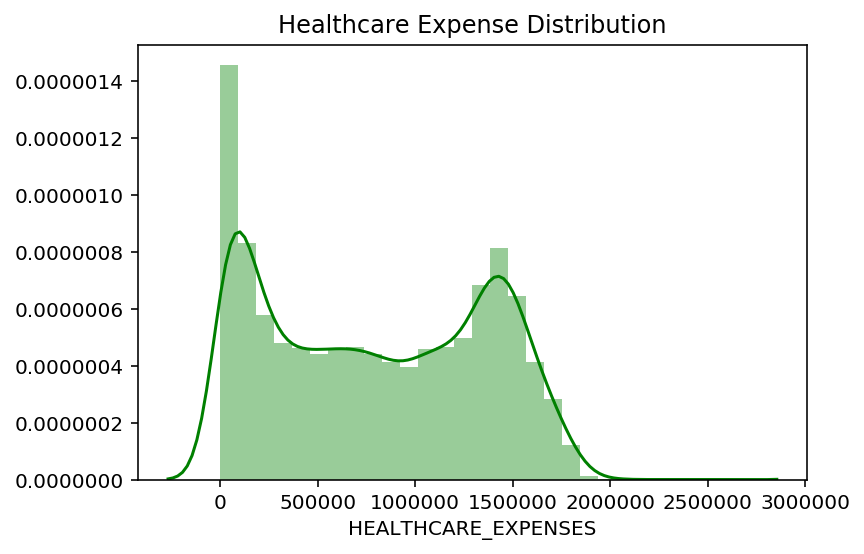

In [88]:
import plotly.figure_factory as ff
import numpy as np
cost_cols = ['PATIENT', 'AGE', 'AGE_BIN', 'GENDER', 'RACE2', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'ZIP']
hist_data = patients['HEALTHCARE_EXPENSES']
ax = sns.distplot(hist_data, color='g')
ax.set(title='Healthcare Expense Distribution')
plt.show()

### By Age

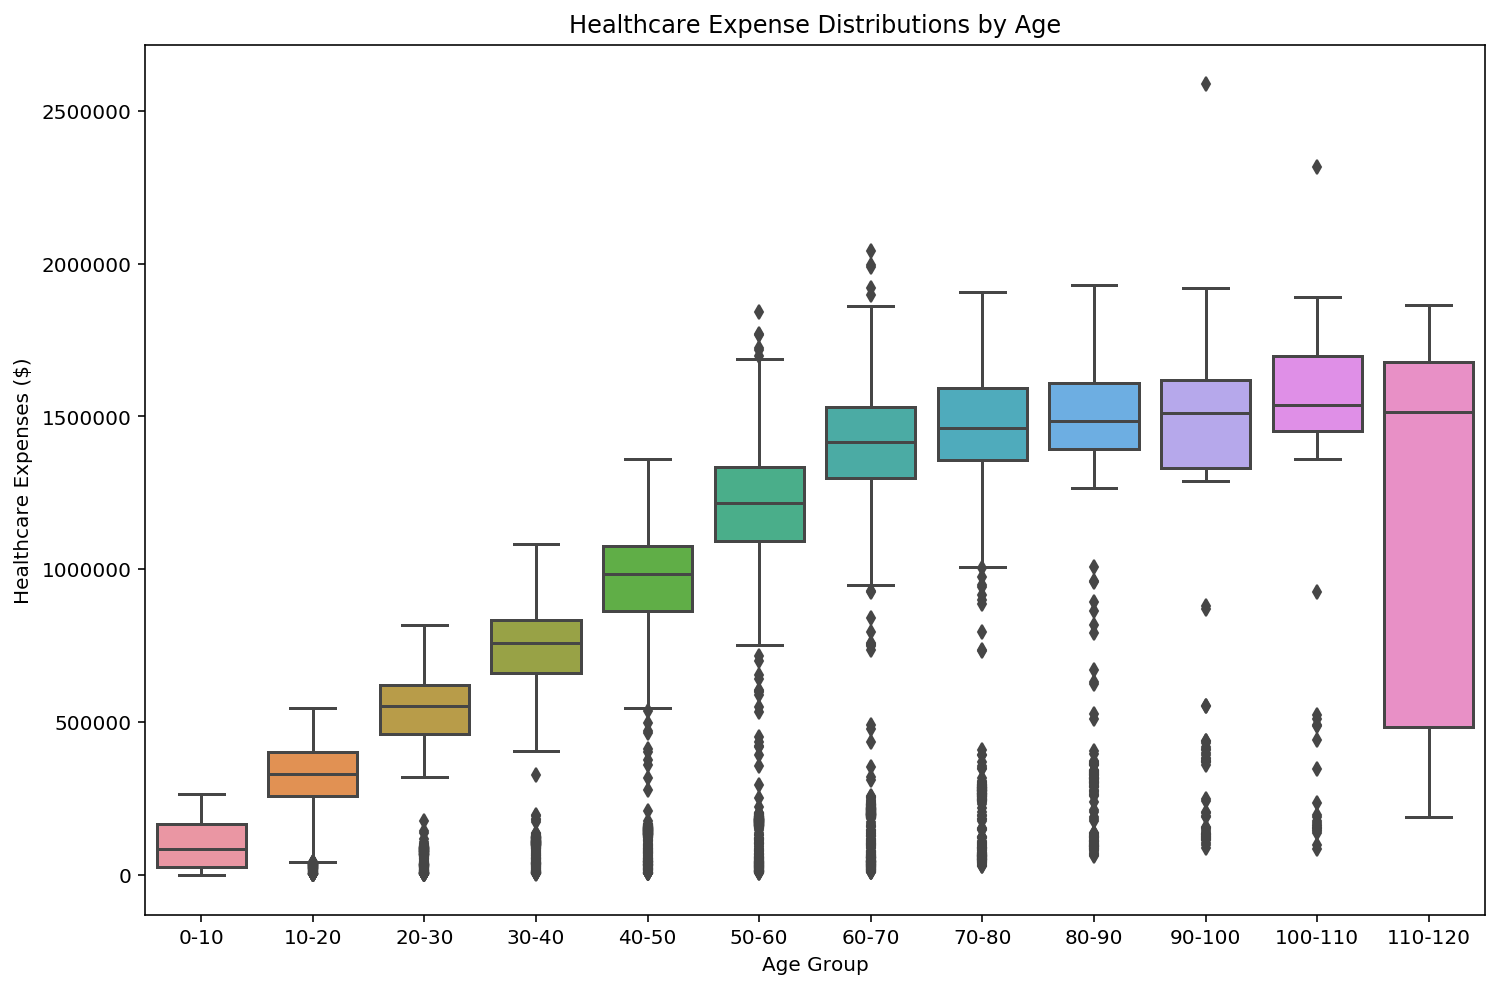

In [89]:
fig, ax = plt.subplots(figsize = (12,8))
patient_sub = patients[cost_cols].sort_values(by='AGE')
sns.boxplot(data=patient_sub, x='AGE_BIN',y='HEALTHCARE_EXPENSES', ax=ax)
ax.set(title='Healthcare Expense Distributions by Age', xlabel='Age Group', ylabel='Healthcare Expenses ($)')
plt.show()